In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets

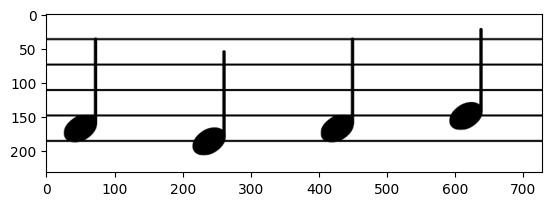

In [48]:
# Step 1: Convert to grayscale
img = cv2.imread('pictures/simplesheet.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
plt.imshow(gray, cmap = 'gray')
plt.show()

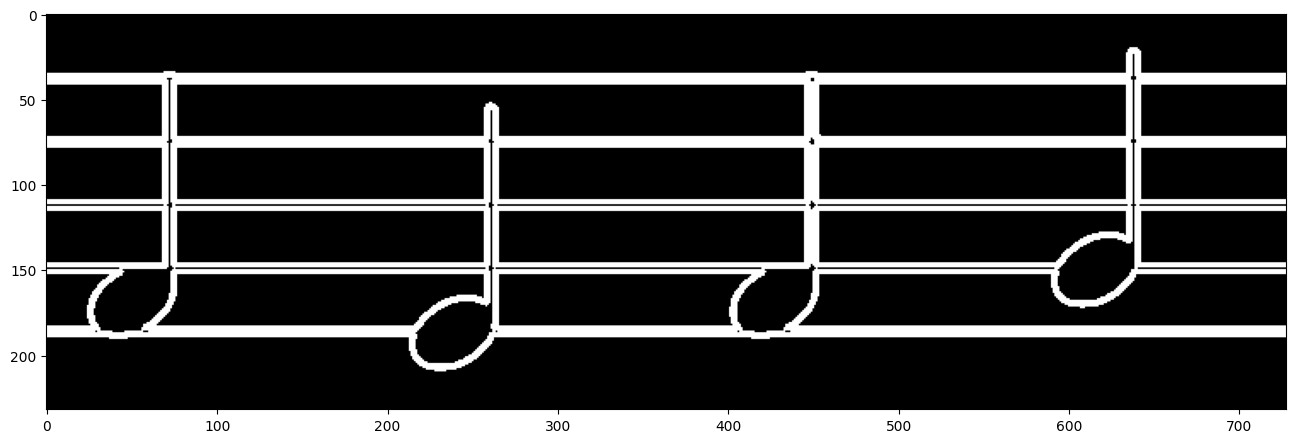

In [49]:
# Step 2: Apply the sobel filter
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = 5)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = 5)
sobel = np.sqrt(sobelx**2 + sobely**2)
sobel = (sobel / sobel.max()*255).astype(np.uint8) # For display purposes and Hough transform
black_white_threshold = 30
sobel[sobel <= black_white_threshold] = 0
sobel[sobel > black_white_threshold] = 255
plt.figure(figsize = (16, 6))
plt.imshow(sobel, cmap='gray')
plt.show()

Number of lines found:  20


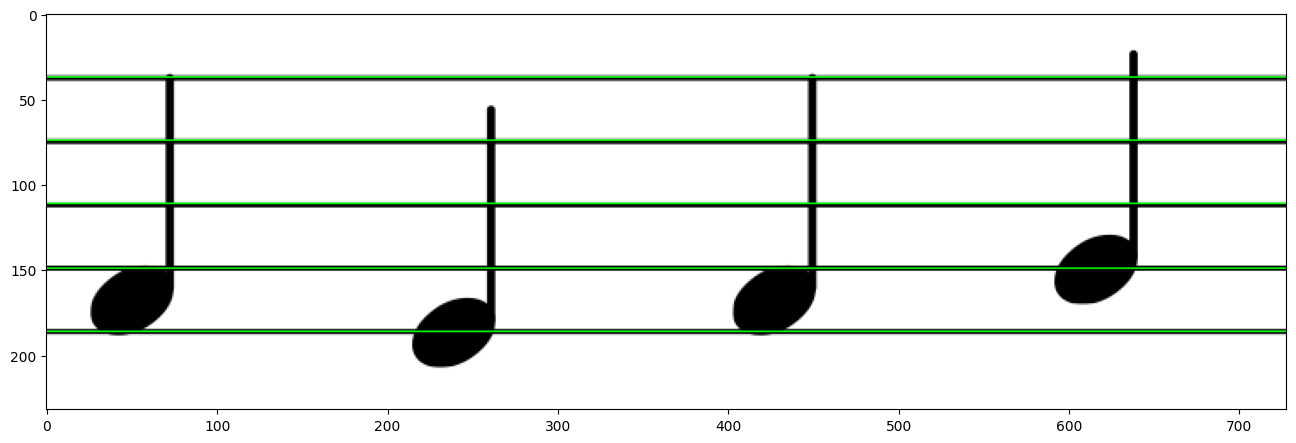

Number of lines of music sheet found: 5
Lines are located at the height:
[37, 74, 111, 149, 186]


In [77]:
# The goal is to find the lines of the music sheet
# In the end, lines stores in order the heights of the lines

# Find the lines of the image using the HoughLinesP function
rho_resolution = 1
theta_resolution = np.pi / 180
threshold = 155
hough_lines = cv2.HoughLinesP(image = (255 - gray).astype(np.uint8), rho = rho_resolution, theta = theta_resolution, threshold = threshold,
                            minLineLength = 100, maxLineGap = 10)
print('Number of lines found: ', len(hough_lines))

# Keep only one line for each line of the music sheet
# Get all lines in a consecutive order
all_lines = []
for i in range(len(hough_lines)):
    line = hough_lines[i]
    for a,b,c,d in line:
        all_lines.append(b)
all_lines.sort()
# Group the lines that are consecutive
all_lines_separated = np.split(all_lines, np.where(np.diff(all_lines) != 1)[0]+1)
# Keep the rounded median for each group
lines = [int(np.median(group)) for group in all_lines_separated]

# Draw the lines on an image
color_line = [0, 255, 0]
thickness = 1
img_with_lines = img.copy()
for line in lines:
    cv2.line(img_with_lines, (0, line), (img.shape[1], line), color_line, thickness)

plt.figure(figsize = (16, 6))
plt.imshow(img_with_lines)
plt.show()
print("Number of lines of music sheet found: " + str(len(lines)))
print("Lines are located at the height:")
print(lines)

In [89]:
# The goal is to get the average height of an interline

interline = round(np.mean([lines[i + 1] - lines[i] for i in range(len(lines) - 1)]))

print(interline)

37


Notes found:
[ 50 166]
[236 186]
[428 166]
[614 150]


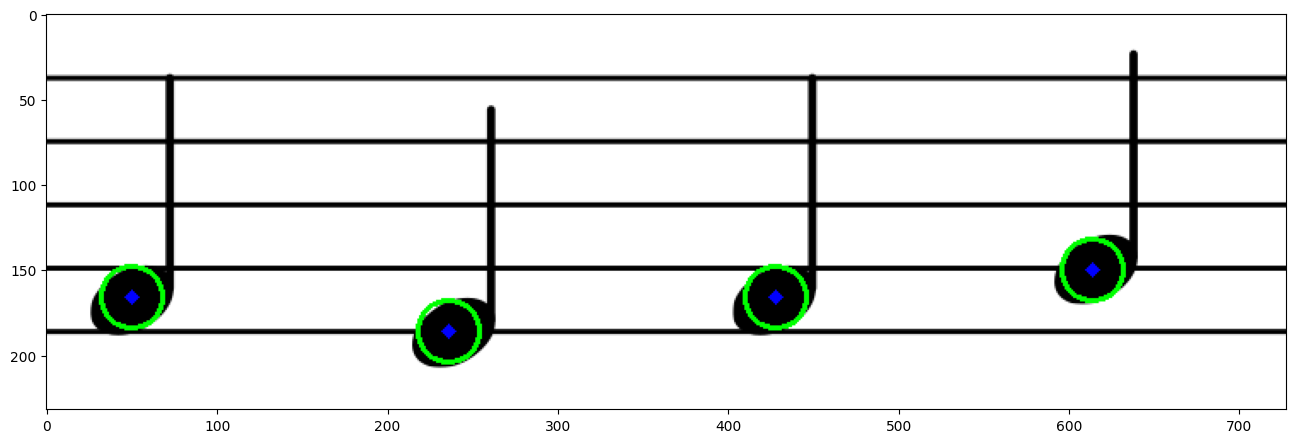

In [96]:
# The goal is to find the notes on the music sheet
# In the end, notes stores in chronological order the centers of the notes

# Find the circles of the image using the HoughCircles function
circles = cv2.HoughCircles(sobel, cv2.HOUGH_GRADIENT, dp = 1, minDist = 20, param1 = 2, param2 = 10,
                             minRadius = int(interline / 2 * 0.8), maxRadius = int(interline / 2 * 1.2))
circles = np.uint16(np.around(circles))

# Keep only the notes (black center)
notes = []
for i in circles[0,:]:
    # only keep the notes (black center):
    if img[i[1], i[0], 0] < 100:
        notes.append(i[:-1])
notes = sorted(notes, key = lambda x : x[0])

# Draw the notes on an image
color_note = [0, 255, 0]
color_note_center = [0, 0, 255]
note_radius = int(interline / 2)
img_with_notes = img.copy()
for note in notes:
    # draw the outer circle
    cv2.circle(img_with_notes, (note[0], note[1]), note_radius, color_note, 2)
    # draw the center of the circle
    cv2.circle(img_with_notes, (note[0], note[1]), 2, color_note_center, 3)

print("Notes found:")
for note in notes:
    print(note)
plt.figure(figsize=(16,6))
plt.imshow(img_with_notes)
plt.show()

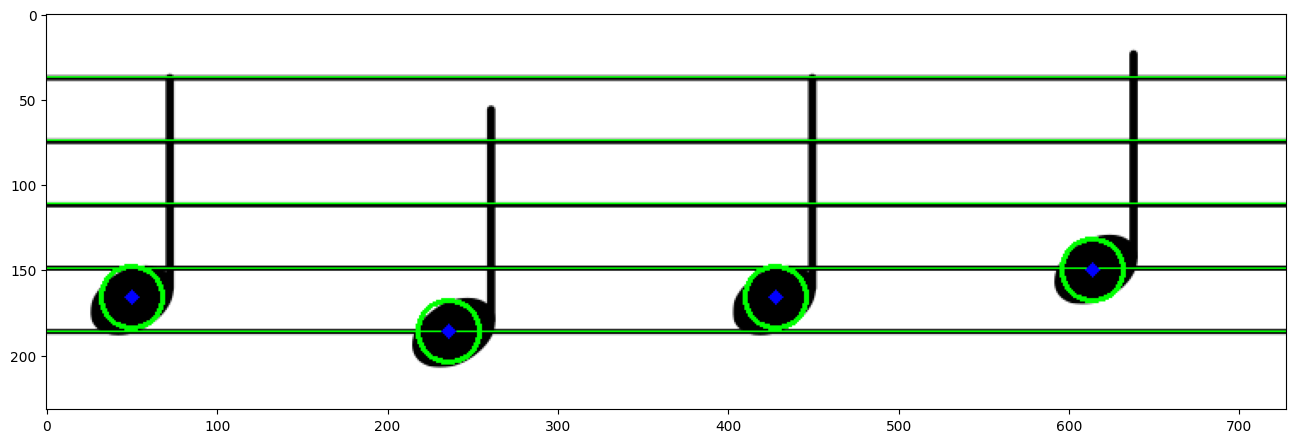

In [97]:
# Combining lines and circles

img_with_all = img.copy()

# Draw the lines on the image
color_line = [0, 255, 0]
thickness = 1
for line in lines:
    cv2.line(img_with_all, (0, line), (img.shape[1], line), color_line, thickness)

# Draw the notes on the image
color_note = [0, 255, 0]
color_note_center = [0, 0, 255]
note_radius = int(interline / 2)
for note in notes:
    # draw the outer circle
    cv2.circle(img_with_all, (note[0], note[1]), note_radius, color_note, 2)
    # draw the center of the circle
    cv2.circle(img_with_all, (note[0], note[1]), 2, color_note_center, 3)
        
plt.figure(figsize=(16,6))
plt.imshow(img_with_all)
plt.show()

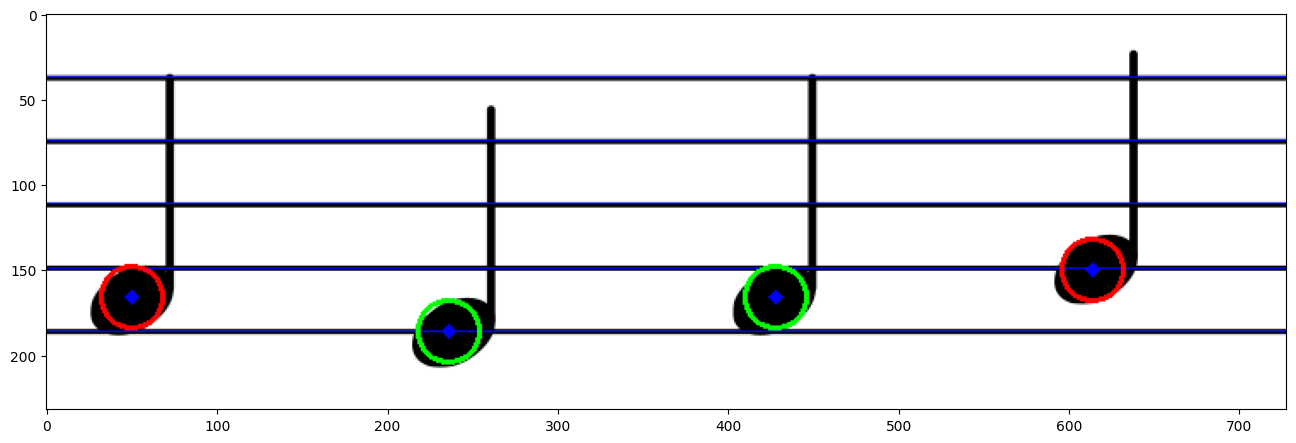

In [160]:
# Combining lines and circles
import random

img_feedback = img.copy()

# Draw the lines on the image
color_line = [0, 0, 255]
thickness = 1
for line in lines:
    cv2.line(img_feedback, (0, line), (img.shape[1], line), color_line, thickness)

# Draw the notes on the image
color_right = [0, 255, 0]
color_wrong = [255, 0, 0]
note_radius = int(interline / 2)
for note in notes:
    # draw the outer circle
    cv2.circle(img_feedback, (note[0], note[1]), note_radius, random.choice([color_right, color_wrong]), 2)
    # draw the center of the circle
    cv2.circle(img_feedback, (note[0], note[1]), 2, color_note_center, 3)
        
plt.figure(figsize=(16,6))
plt.imshow(img_feedback)
plt.show()

In [129]:
# Create the notes

base_notes = lines.copy()
for i in range(1, len(lines)):
    base_notes.append(int((lines[i] + lines[i - 1]) / 2))
base_notes.sort()

base_notes_names =['Mi4', 'Fa4', 'Sol4', 'La4', 'Si4', 'Do5', 'Ré5', 'Mi5', 'Fa5']
base_notes_names.reverse()

dic_note_to_int = {}
dic_int_to_note = {}
for i in range(len(base_notes_names)):
    dic_note_to_int[base_notes_names[i]] = base_notes[i]
    dic_int_to_note[base_notes[i]] = base_notes_names[i]

print(dic_notes)

{'Fa5': 37, 'Mi5': 55, 'Ré5': 74, 'Do5': 92, 'Si4': 111, 'La4': 130, 'Sol4': 149, 'Fa4': 167, 'Mi4': 186}


In [148]:
# The goal is to recognise the notes

def closest_note(note):
    return base_notes[np.array(abs(base_notes - note[1])).argmin()]

for note in notes:
    print(dic_int_to_note.get(closest_note(note)))

Fa4
Mi4
Fa4
Sol4


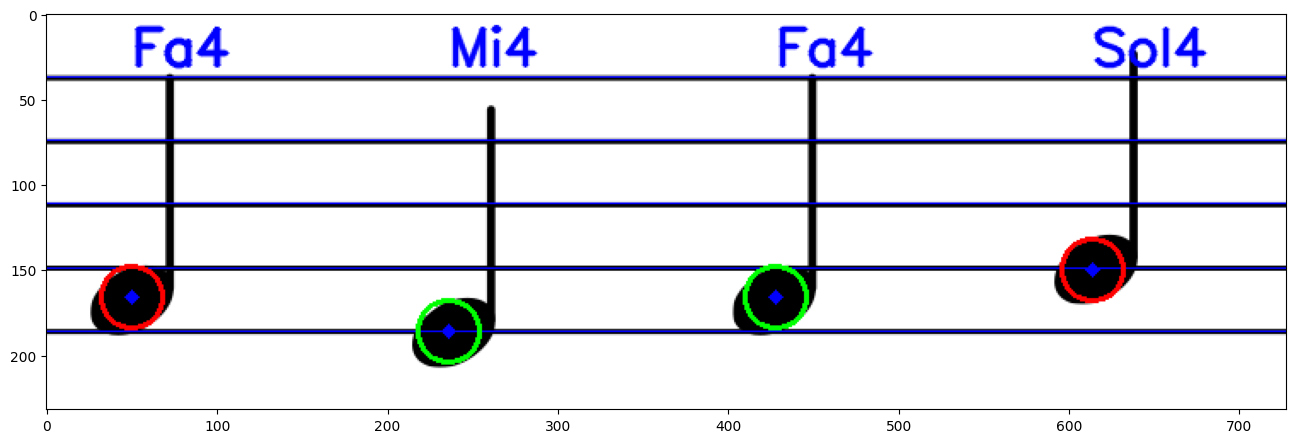

In [162]:
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
color = (0, 0, 255)
thickness = 2
img_text = img_feedback.copy()

for note in notes:
    img_text = cv2.putText(img_feedback, dic_int_to_note.get(closest_note(note)), (note[0], 30),
                       font, fontScale, color, thickness, cv2.LINE_AA)

plt.figure(figsize=(16,6))
plt.imshow(img_text)
plt.show()